# Feature selection lab - Golub
Lab developed by Gary Marigliano - 07.2018

## Introduction

In this notebook, we are going to use the Golub dataset which contains about 7000 features, 72 samples and 2 classes (AML and ALL). 

The goal is to get lists of relevant features (100 or less) using several FS techniques. The idea is to combine several lists of features to get "super" lists that should (maybe) perform better than only one list. To merge the lists you are going to be creative (take the union/intersection between all the lists, use the the feature's importance score as a weight or a probability to select this feature from a list,...).

## Rules to build a super list

* The super list must contain 100 features or less
* You are not forced to use all the lists to build the super list
* The super list must not contain duplicate features
* The super list must at least use features from 2 different FS techniques

You can use some features selection algorithms listed here (the python library should already been installed for this project): http://featureselection.asu.edu/html/skfeature.function.html and http://featureselection.asu.edu/tutorial.php


## TODO in this notebook

Answer the questions in this notebook (where **TODO student** is written)

In [0]:
import glob
import pandas as pd
from sklearn import preprocessing

In [2]:
le_classes = preprocessing.LabelEncoder()
le_classes.fit(["AML", "ALL"])

LabelEncoder()

In [0]:
def parse_dataset(filenames, le_classes):
    df = pd.read_csv(filenames[0], sep="\t", usecols=["ID_REF", "VALUE"]).transpose().drop("ID_REF", axis=0)
    df.index = [filenames[0].split("/")[-1]]

    for i in range(1, len(filenames)):
        df2 = pd.read_csv(filenames[i], sep="\t", usecols=["ID_REF", "VALUE"]).transpose().drop("ID_REF", axis=0)
        df2.index = [filenames[i].split("/")[-1]]

        df = pd.concat([df, df2])

    X = df.values

    y = [fname[-7:-4] for fname in df.index.values]
    y = le_classes.transform(y)

    
    return X, y

In [4]:
train_filenames = glob.glob("./datasets/golub/train/*.csv")
test_filenames = glob.glob("./datasets/golub/test/*.csv")

X_train, y_train = parse_dataset(train_filenames, le_classes)
X_test, y_test = parse_dataset(test_filenames, le_classes)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(38, 7129) (38,) (34, 7129) (34,)


In [5]:
df = pd.read_csv(train_filenames[0], sep="\t", usecols=["ID_REF", "VALUE"]).transpose().drop("VALUE", axis=0)
features_name = df.values[0]
print(features_name)

['AFFX-BioB-5_at' 'AFFX-BioB-M_at' 'AFFX-BioB-3_at' ..., 'L49218_f_at'
 'M71243_f_at' 'Z78285_f_at']


**TODO student**

* Get 3 super lists using at least 2 different FS techniques. This is an example to build a super list:
    * FS techniques: ExtraTrees + Fisher score; Merge technique: intersection of the lists
    * FS techniques: Recursive Feature Elimination SVM + ANN + MRMR: pick K features with a probability based on the feature importance's score
* For each super list:
    * Get the `evaluate_features()` function you wrote in 02-WDBC
    * Use this function with the super list
    * Use this function with a random list of selected features (same size as the super list)
    * Use this function with all the features
    * Make a plot similar to the one just below (see https://matplotlib.org/examples/api/barchart_demo.html)
    * Comment the results. Here are some clues about the questions you should ask yourself:
        * How the scores of the lists of selected features behave compare to the random/all features ?
        * How behave the classifiers inside `evaluate_features()` ? Do they prefer a list in general ?
        
* You may be careful to the following points:
   * the classifiers you use may not be determinist therefore you may want to run them multiple time to have an averaged score
   * try to choose classifiers that are relatively different regarding how they use the data. Using 3 classifiers that are tree-based is not the best idea you can have
   * try to choose classifiers that you didn't use to get the lists of features in the first place

* Comment your results. Here are some clues about the questions you should ask yourself:
    * What kind of problems could you encounter when merging the lists ?
    * Do the super lists that use more lists perform better ?
    * What about the execution time ?

<img src="assets/02-WDBC-perf-plot.png" />

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
from skfeature.function.similarity_based import fisher_score
from skfeature.function.statistical_based import f_score
from skfeature.function.statistical_based import t_score


import numpy as np

## First list

# train
clf = ExtraTreesClassifier(n_jobs=2, n_estimators=100)
clf.fit(X_train, y_train)
importances = clf.feature_importances_
n = len(importances)

# get best 100 features from ExtraTrees
sorted_x = np.argsort(-importances)
sorted_x = sorted_x[:100]

# get best 100 features from Fischer score
score_fisher = fisher_score.fisher_score(X_train, y_train)
idx_fisher = fisher_score.feature_ranking(score_fisher)
idx_fisher = idx_fisher[:100]

# Merge using intersection
merged_list1 = np.intersect1d(sorted_x, idx_fisher)
print(merged_list1.shape)




(29,)


In [39]:
## Second list
# Same as first list with F-score instead of Fischer

# train
clf = ExtraTreesClassifier(n_jobs=2, n_estimators=100)
clf.fit(X_train, y_train)
importances = clf.feature_importances_

# get best 100 features from ExtraTrees
sorted_x = np.argsort(-importances)
sorted_x = sorted_x[:100]


# get best 100 features from F-score
score_f = f_score.f_score(X_train, y_train)
idx_f = f_score.feature_ranking(score_f)
idx_f = idx_f[:100]

merged_list2 = np.intersect1d(sorted_x, idx_f)
print(merged_list2.shape)

(29,)


In [40]:
## Third list
# get top 20 features of all three metrics from Part 2 as well as Extratrees. Concatenate and remove duplicates.

# train
clf = ExtraTreesClassifier(n_jobs=2, n_estimators=100)
clf.fit(X_train, y_train)
importances = clf.feature_importances_

# get best 20 features from ExtraTrees
sorted_x = np.argsort(-importances)
sorted_x = sorted_x[:20]
sorted_x.ravel()

# get best 20 features from Fischer score
score_fisher = fisher_score.fisher_score(X_train, y_train)
idx_fisher = fisher_score.feature_ranking(score_fisher)
idx_fisher = idx_fisher[:20]

# get best 20 features from F-score
score_f = f_score.f_score(X_train, y_train)
idx_f = f_score.feature_ranking(score_f)
idx_f = idx_f[:20]

# get best 20 features from T-score
score_t_score = t_score.t_score(X_train, y_train)
idx_t_score = t_score.feature_ranking(score_t_score)
idx_t_score = idx_t_score[:20]


merged_list3 = np.concatenate((sorted_x, idx_fisher))
temp = np.concatenate((idx_f, idx_t_score))
merged_list3 = np.unique(np.concatenate((merged_list3, temp)))
print(merged_list3.shape)

(45,)


In [0]:
import matplotlib.pyplot as plt

def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/4., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
            
def find_a_way_to_show_these_scores_nicely(index, score_clf_1, score_clf_2, score_clf_3): 
    N_features = 3
    score_clf_1_mean = score_clf_1[0]
    score_clf_1_std = score_clf_1[1]
    
    score_clf_2_mean = score_clf_2[0]
    score_clf_2_std = score_clf_2[1]
    
    score_clf_3_mean = score_clf_3[0]
    score_clf_3_std = score_clf_3[1]

    ind = np.arange(N_features)  # the x locations for the groups
    width = 0.20       # the width of the bars

    fig, ax = plt.subplots(figsize=(15,5))
    rects1 = ax.bar(ind, score_clf_1_mean, width, color='b', yerr=score_clf_1_std)
    rects2 = ax.bar(ind + width, score_clf_2_mean, width, color='orange', yerr=score_clf_2_std)
    rects3 = ax.bar(ind + 2*width, score_clf_3_mean, width, color='g', yerr=score_clf_3_std)


    # add some text for labels, title and axes ticks
    ax.set_ylabel('Scores')
    ax.set_title('Scores by classifiers and by lists of '+str(len(index))+' features')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(('Selected Features','Random Features','All Features'))

    ax.legend((rects1[0], rects2[0], rects3[0]), ('KNN', 'LinearSVC','MLP'),loc='upper left')

    autolabel(rects1,ax)
    autolabel(rects2,ax)
    autolabel(rects3,ax)

    plt.show()
    
def evaluate_features(features):
    score_clf_1 = compute_score_using_classifier_1(features)
    score_clf_2 = compute_score_using_classifier_2(features)
    score_clf_3 = compute_score_using_classifier_3(features)
    # ....
    return find_a_way_to_show_these_scores_nicely(features,score_clf_1, score_clf_2, score_clf_3)

def compute_score_using_classifier_1(features):
    # KNN
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score
    
    selected_features_train = X_train[:, features]
    selected_features_test = X_test[:, features]
    
    select_acc_list_1 = []
    runs = 5
    for i in range(runs):
        knn = KNeighborsClassifier(n_neighbors=i+1)
        knn.fit(selected_features_train, y_train)
        y_predict = knn.predict(selected_features_test)
        acc = accuracy_score(y_test, y_predict)
        #print(acc)
        select_acc_list_1.append(acc)
        
    from random import randint
    random_features_list = []
    for i in range(len(features)):
        random_features_list.append(randint(0, X_train.shape[1]-1))
    random_features_train = X_train[:, random_features_list]
    random_features_test = X_test[:, random_features_list]
    
    rnd_acc_list_1 = []
    runs = 5
    for i in range(runs):
        knn = KNeighborsClassifier(n_neighbors=i+1)
        knn.fit(random_features_train, y_train)
        y_predict = knn.predict(random_features_test)
        acc = accuracy_score(y_test, y_predict)
        rnd_acc_list_1.append(acc)
        
    all_acc_list_1 = []
    runs = 5
    for i in range(runs):
        knn = KNeighborsClassifier(n_neighbors=i+1)
        knn.fit(X_train, y_train)
        y_predict = knn.predict(X_test)
        acc = accuracy_score(y_test, y_predict)
        all_acc_list_1.append(acc)
    
    
    return ([np.mean(select_acc_list_1),np.mean(rnd_acc_list_1),np.mean(all_acc_list_1)], [np.std(select_acc_list_1),np.std(rnd_acc_list_1),np.std(all_acc_list_1)])

def compute_score_using_classifier_2(features):
    # LinearSVC
    from sklearn import svm
    clf = svm.LinearSVC()
    from sklearn.metrics import accuracy_score
    
    selected_features_train = X_train[:, features]
    selected_features_test = X_test[:, features]
    
    select_acc_list_2 = []
    runs = 5
    for i in range(runs):
        clf.fit(selected_features_train, y_train)
        y_predict = clf.predict(selected_features_test)
        acc = accuracy_score(y_test, y_predict)
        select_acc_list_2.append(acc)
        
    from random import randint
    random_features_list = []
    for i in range(len(features)):
        random_features_list.append(randint(0, X_train.shape[1]-1))
    random_features_train = X_train[:, random_features_list]
    random_features_test = X_test[:, random_features_list]
    
    rnd_acc_list_2 = []
    runs = 5
    for i in range(runs):
        clf.fit(random_features_train, y_train)
        y_predict = clf.predict(random_features_test)
        acc = accuracy_score(y_test, y_predict)
        rnd_acc_list_2.append(acc)
        
    all_acc_list_2 = []
    runs = 5
    for i in range(runs):
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        acc = accuracy_score(y_test, y_predict)
        all_acc_list_2.append(acc)
    
    return ([np.mean(select_acc_list_2),np.mean(rnd_acc_list_2),np.mean(all_acc_list_2)], [np.std(select_acc_list_2),np.std(rnd_acc_list_2),np.std(all_acc_list_2)])

def compute_score_using_classifier_3(features):
    # MLP
    from sklearn.preprocessing import StandardScaler
    
    selected_features_train = X_train[:, features]
    selected_features_test = X_test[:, features]
    
    scaler = StandardScaler()  
    scaler.fit(selected_features_train)

    selected_features_train = scaler.transform(selected_features_train)  
    selected_features_test = scaler.transform(selected_features_test)
    
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import accuracy_score
    select_acc_list_3 = []
    runs = 5
    for i in range(runs):
        mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)  
        mlp.fit(selected_features_train, y_train)
        y_predict = mlp.predict(selected_features_test)
        acc = accuracy_score(y_test, y_predict)
        select_acc_list_3.append(acc) 
        
    from random import randint
    random_features_list = []
    for i in range(len(features)):
        random_features_list.append(randint(0, X_train.shape[1]-1))
    random_features_train = X_train[:, random_features_list]
    random_features_test = X_test[:, random_features_list]

    scaler = StandardScaler()  
    scaler.fit(random_features_train)
    random_features_train = scaler.transform(selected_features_train)  
    random_features_test = scaler.transform(selected_features_test)
    
    rdn_acc_list_3 = []
    runs = 5
    for i in range(runs):
        mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)  
        mlp.fit(random_features_train, y_train)
        y_predict = mlp.predict(random_features_test)
        acc = accuracy_score(y_test, y_predict)
        rdn_acc_list_3.append(acc)
    
    scaler = StandardScaler()  
    scaler.fit(X_train)
    all_features_train = scaler.transform(X_train)  
    all_features_test = scaler.transform(X_test)
    
    all_acc_list_3 = []
    runs = 5
    for i in range(runs):
        mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)  
        mlp.fit(all_features_train, y_train)
        y_predict = mlp.predict(all_features_test)
        acc = accuracy_score(y_test, y_predict)
        all_acc_list_3.append(acc) 
    
    return ([np.mean(select_acc_list_3),np.mean(rdn_acc_list_3),np.mean(all_acc_list_3)], [np.std(select_acc_list_3),np.std(rdn_acc_list_3),np.std(all_acc_list_3)])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


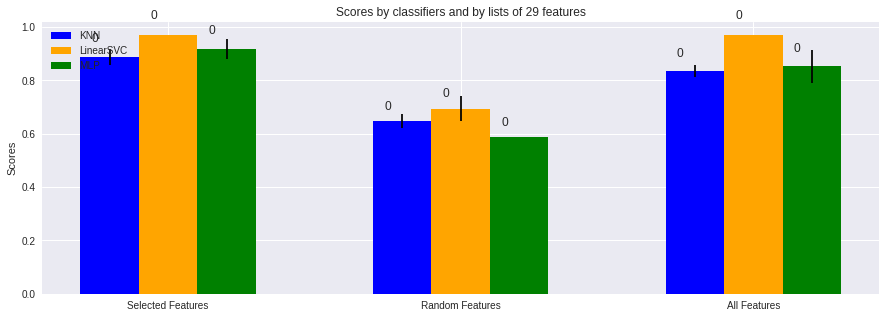

In [49]:
## First list evaluation
evaluate_features(merged_list1)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


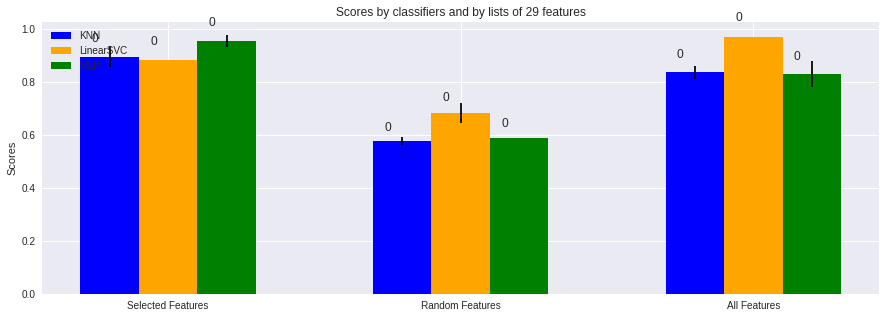

In [50]:
## Second list evaluation
evaluate_features(merged_list2)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


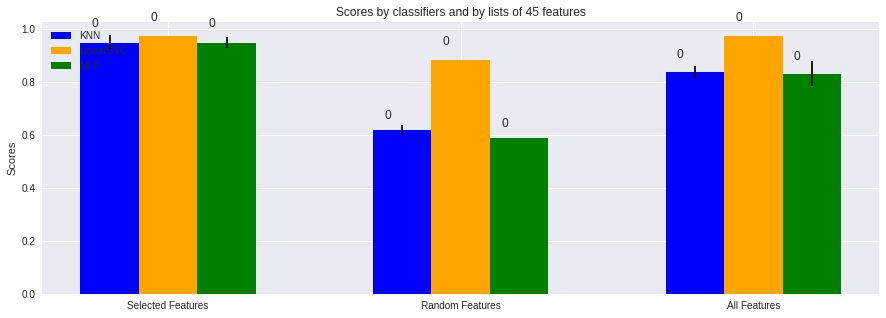

In [51]:
## Third list evaluation
evaluate_features(merged_list3)


## List comments

For the first super list, the results using selected features are close to the results using all features. This means we managed to select meaningful features using our method, which accurately represent results using all features. However, since performance is not strictly better than when using all features, we did not manage to remove noise using this list.

For the second super list, performance is better for KNN and MLP classifiers when using selected features. While this is not the case for the LinearSVC, 

For the third super list, the classifier results using the selected features has the highest accuracy of all, and this for each one of the three classifiers. We successfully managed to reduce noise using this list since our performance is superior to the "all features" results.

For all three lists, the random results are similiar, since no large differences in size appear in our superlists (30-40 elements on average depending on execution).

The major difference between classifiers is that LinearSVC usually beforms better on random and All features, however the gap closes a lot when using selected features. Since Support Vector Machines perform dimentionality reduction, they are very effective in high dimentional space. This explains their much better performance than our other two classifiers in All feature categories.

## Method comments

### What kind of problems could you encounter when merging the lists ?
When calculating the intersection of lists using intersect1d, the resulting array is sorted and therefore we cannot intersect very large lists then take the first 100 as our super list. We therefore have to limit each list to size 100 and we get a much smaller list after intersecting.

The problem of repeat features when concatenating in the third list was solved simply by removing duplicates, however this reduces the size of the list depending on how many features are ranked the best by multiple scorers.

A final problem we might face is simply the list being too small: each execution giving different results, we could have a list as small as 20 features for the final list if each scorer gives the same 20 features as output. Since we are imposed a maximum of 100 features in this exercise, we have to use methods that cannot give more features than that.
    
### Do the super lists that use more lists perform better ?
Yes, our final super list which combines four different lists has the best performance. Since it uses the best features from each list, we end up with the most important features that each feature selection method can detect. After removing duplicates, this results in a "best overall" selection of features.

### What about the execution time ?
None of our super lists took longer than a few milliseconds, however they all used similar selection methods. We did not use any very computationaly intensive methods and thus cannot rank the methods by their performance/calculation time.

